## Dashboard for monitoring scraping ,embedding, etc

notebooks/Dashboard.ipynb

### EDA on pdf metadata

In [505]:
import json
from pathlib import Path
import pandas as pd
from collections import Counter

#### Preparation

In [506]:
import json
import pandas as pd
from pathlib import Path
from IPython.display import display

# === Load Manifest ===
def load_manifest(path):
    rows = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                row = json.loads(line)
                rows.append(row)
            except:
                continue
    return pd.DataFrame(rows)

def summarise_manifest(df, stage_name):
    if 'doc_id' not in df:
        return pd.DataFrame({stage_name: ['No entries'], 'count': [0]})
    
    boolean_cols = [col for col in df.columns if col not in {'doc_id', 'timestamp'} and df[col].dropna().nunique() <= 2]
    counters = {}
    
    for col in boolean_cols:
        count = df[col].value_counts().to_dict()
        for k in [True, False]:
            label = f"{col}: {k}"
            counters[label] = count.get(k, 0)
    
    return pd.DataFrame(list(counters.items()), columns=[stage_name, 'count'])


#### The Scraping Dashboard

In [507]:
# === Load scraping progress ===
pdf_manifest_path = Path("../data/processed_register/pdf_manifest.jsonl")
pdf_manifest = load_manifest(pdf_manifest_path)

# === Load metadata summary ===
metadata_path = Path("../data/pdf_metadata/scraped_pdf_metadata.jsonl")
df = pd.read_json(metadata_path, lines=True)

# === Display scraping progress ===
print("📄 PDF Scraping Progress")
pdf_summary = summarise_manifest(pdf_manifest, "PDFs")
display(pdf_summary)

# === Display metadata summary ===
print(f"🧾 Metadata Extracted for {len(df)} PDFs")
display(df.tail(2))

📄 PDF Scraping Progress


,PDFs,count
0,scraped: True,2637
1,scraped: False,11427
2,summarised: True,0
3,summarised: False,14064
4,chunked: True,0
5,chunked: False,14064
6,embedded: True,0
7,embedded: False,14064


🧾 Metadata Extracted for 2637 PDFs


,format,title,author,creator,producer,creationDate,modDate,num_tables_detected,metadata_title,source_filename,doc_id,subject,keywords,encryption
2635,PDF 1.7,(Public Pack)Agenda Document for Kent and Medw...,NaN,Aspose Ltd.,Aspose.Pdf for .NET 11.9.0,D:20181001132723+01'00',D:20181001132723+01'00',25,(Public Pack)Agenda Document for Kent and Medw...,report pack.pdf,kcc_cc_2018-10-09_6968e3,Kent and Medway Joint Health and Wellbeing Boa...,"Council meetings;Government, politics and publ...",NaN
2636,PDF 1.5,Agenda Template,Authorised User,Microsoft Office Word,Aspose.Words for .NET 16.7.0.0,D:20120509094300Z,D:20181023172400Z,0,Agenda Template,minutes.pdf,kcc_cc_2018-10-09_e06e71,NaN,NaN,NaN


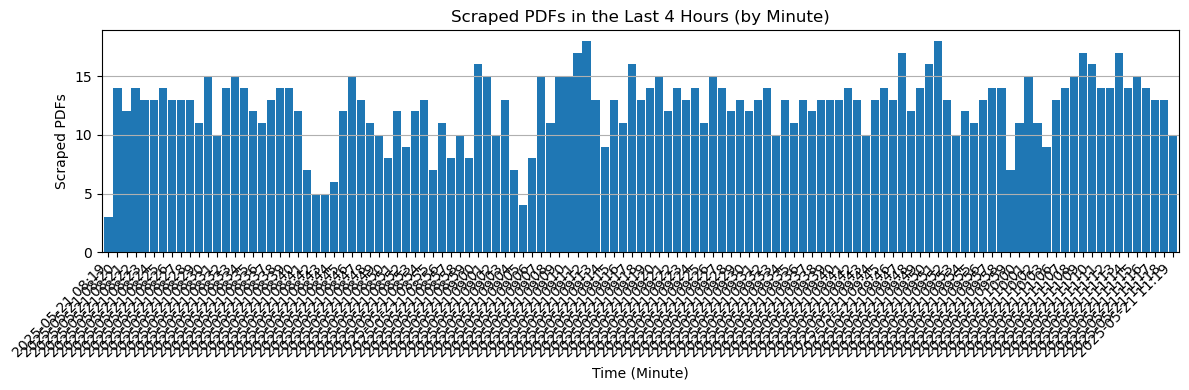

In [508]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

# Ensure timestamps are datetime
pdf_manifest["timestamp"] = pd.to_datetime(pdf_manifest["timestamp"], errors="coerce")

# Filter for the last 2 hours
now = datetime.now()
cutoff = now - timedelta(hours=3)
recent = pdf_manifest[pdf_manifest["timestamp"] >= cutoff]

# Group by minute
grouped_recent = recent.groupby(recent["timestamp"].dt.to_period("min")).size()

# Plot
plt.figure(figsize=(12, 4))
grouped_recent.plot(kind="bar", width=0.9)
plt.title("Scraped PDFs in the Last 4 Hours (by Minute)")
plt.xlabel("Time (Minute)")
plt.ylabel("Scraped PDFs")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.grid(axis="y")
plt.show()

🧾 Metadata Extracted for 2637 PDFs


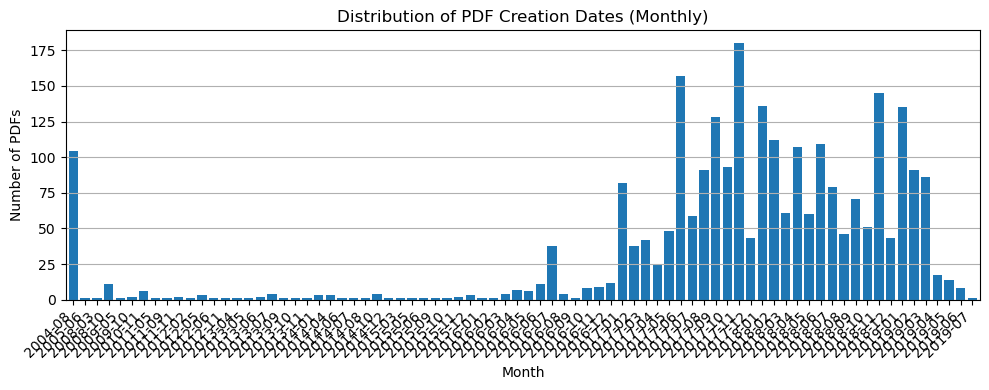

In [509]:
import matplotlib.pyplot as plt

# Parse the creation date — using only the YYYYMMDD part from the PDF metadata
df["created"] = pd.to_datetime(
    df["creationDate"].str.extract(r"D:(\d{8})")[0],
    format="%Y%m%d",
    errors="coerce"
)

# Drop NaT values for plotting
timeline = df.dropna(subset=["created"])

# Group by month or year (you can switch between these)
timeline_grouped = timeline.groupby(timeline["created"].dt.to_period("M")).size()

print(f"🧾 Metadata Extracted for {len(df)} PDFs")
# Plot the timeline
plt.figure(figsize=(10, 4))
timeline_grouped.plot(kind="bar", width=0.8)
plt.title("Distribution of PDF Creation Dates (Monthly)")
plt.xlabel("Month")
plt.ylabel("Number of PDFs")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.grid(axis='y')
plt.show()

#### Missing values, etc

In [510]:
print("\n📊 Missing Values by Column")
display(df.isna().sum().sort_values(ascending=False))

print("\n📈 Metadata Field Stats")
display(df.describe(include='all'))

for col in ["author", "creator", "producer", "title"]:
    if col in df.columns:
        print(f"\n🔍 Most Common Values for {col}")
        display(df[col].value_counts().head(10))


📊 Missing Values by Column


encryption             2626
subject                2597
keywords               2575
title                  1121
author                  234
creator                  76
producer                 67
modDate                  27
created                   6
creationDate              5
format                    0
num_tables_detected       0
metadata_title            0
source_filename           0
doc_id                    0
dtype: int64


📈 Metadata Field Stats


,format,title,author,creator,producer,creationDate,modDate,num_tables_detected,metadata_title,source_filename,doc_id,subject,keywords,encryption,created
count,2637,1516,2403,2561,2570,2632,2610,2637.000000,2637,2637,2637,40,62,11,2631
unique,5,211,455,59,56,2347,2492,NaN,212,2467,2637,23,18,1,NaN
top,PDF 1.5,THE REPORT,fitchd01,Microsoft Office Word,Aspose.Words for .NET 16.2.0.0,D:20040805123000Z,D:20190227161551+00'00',NaN,,Minutes of Previous Meeting.pdf,kcc_cc_2017-04-11_0a80ac,Paul Wickenden,"Council meetings;Government, politics and publ...",Standard V4 R4 128-bit AES,NaN
freq,2279,303,358,1999,1086,59,5,NaN,1121,54,1,11,29,11,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.722412,NaN,NaN,NaN,NaN,NaN,NaN,2017-06-10 11:32:54.458380800
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,2004-08-05 00:00:00
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,2017-06-28 00:00:00
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-15 00:00:00
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,2018-09-04 00:00:00
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,141.000000,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-03 00:00:00



🔍 Most Common Values for author


author
fitchd01                       358
Fiona Treveil                  280
KCC                            190
Planning Department            188
GrahaA01                        45
Miranda Jayne Barnard           45
Grayell, Theresa - BSS GL       35
Lara                            25
West, Emma - ST GL              21
Romagnuolo, Gaetano - ST BI     20
Name: count, dtype: int64


🔍 Most Common Values for creator


creator
Microsoft Office Word              1999
Microsoft® Word 2010                 70
Microsoft® Word for Office 365       58
Microsoft® Word 2016                 48
PScript5.dll Version 5.2.2           47
Neevia DC Pro - PSPDF parser         41
Acrobat PDFMaker 10.1 for Word       29
Microsoft® Excel® 2010               22
Aspose.Cells                         18
Acrobat PDFMaker 10.1 for Excel      15
Name: count, dtype: int64


🔍 Most Common Values for producer


producer
Aspose.Words for .NET 16.2.0.0                              1086
Aspose.Words for .NET 16.7.0.0                               895
Microsoft® Word 2010                                          70
Microsoft® Word for Office 365                                58
Adobe PDF Library 10.0                                        52
Microsoft® Word 2016                                          48
Acrobat Distiller 10.1.16 (Windows)                           42
Neevia Document Converter Pro v6.1 ( http://neevia.com )      39
Microsoft® Excel® 2010                                        22
Adobe PDF Library 15.0                                        21
Name: count, dtype: int64


🔍 Most Common Values for title


title
THE REPORT                                                                           303
Minutes                                                                              271
KENT COUNTY COUNCIL                                                                  103
By:                                                                                   77
Item No                                                                               55
Report for:                      Social Care and Health policy Overview Committee     45
Discussion                                                                            44
CUSTOMER IMPACT ASSESSMENT REPORT TEMPLATE                                            36
Executive Decision Report                                                             35
Background Note                                                                       27
Name: count, dtype: int64

In [511]:
pdf_manifest

,doc_id,scraped,summarised,chunked,embedded,timestamp,metadata_path,error_msg
0,kcc_cc_2016-06-22_d5312b,True,False,False,False,2025-05-21 00:33:02.828060,data/pdf_metadata/kcc_cc_2016-06-22_d5312b.json,NaN
1,kcc_cc_2016-07-13_0d5be3,True,False,False,False,2025-05-21 00:33:07.631200,data/pdf_metadata/kcc_cc_2016-07-13_0d5be3.json,NaN
2,kcc_cc_2016-07-13_2f8155,True,False,False,False,2025-05-21 00:33:14.676465,data/pdf_metadata/kcc_cc_2016-07-13_2f8155.json,NaN
3,kcc_cc_2016-07-13_c88d53,True,False,False,False,2025-05-21 00:33:17.567093,data/pdf_metadata/kcc_cc_2016-07-13_c88d53.json,NaN
4,kcc_cc_2016-07-13_31517f,True,False,False,False,2025-05-21 00:33:22.160128,data/pdf_metadata/kcc_cc_2016-07-13_31517f.json,NaN
...,...,...,...,...,...,...,...,...
14059,kcc_cc_2016-04-29_973814,False,False,False,False,2025-05-21 00:31:18.723906,NaN,NaN
14060,kcc_cc_2016-04-29_5b61b6,False,False,False,False,2025-05-21 00:31:18.723915,NaN,NaN
14061,kcc_cc_2016-04-29_5a2f5b,False,False,False,False,2025-05-21 00:31:18.723924,NaN,NaN
14062,kcc_cc_2016-06-06_00da22,False,False,False,False,2025-05-21 00:31:18.723933,NaN,NaN


📄 Total text files: 2765
📦 Total size: 51.85 MB
📊 Average size: 19.20 KB
🧮 Average words per file: ~3,168


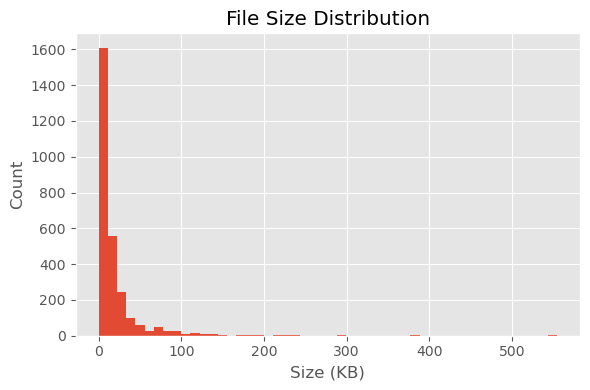

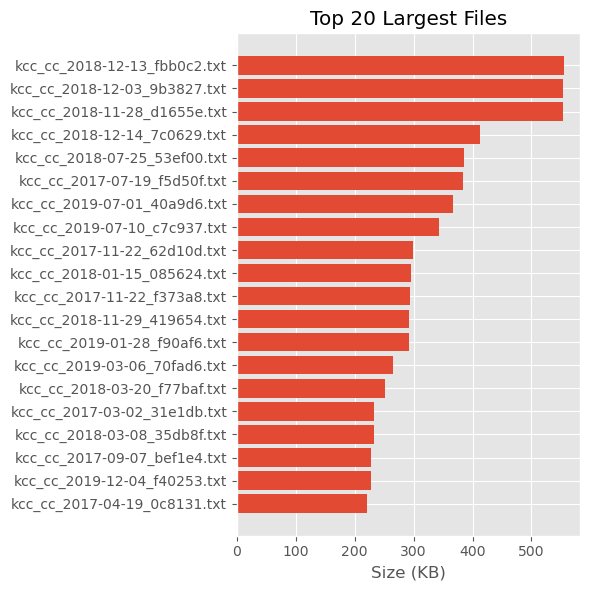

In [516]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use("ggplot")
PDF_TEXT_DIR = Path("../data/pdf_full_text/")

# Load all .txt files and their sizes
files = list(PDF_TEXT_DIR.glob("*.txt"))
data = pd.DataFrame({
    "filename": [f.name for f in files],
    "size_bytes": [f.stat().st_size for f in files]
})
data["size_kb"] = data["size_bytes"] / 1024

# Summary stats
total_size_mb = data["size_bytes"].sum() / (1024 * 1024)
average_size_kb = data["size_kb"].mean()

print(f"📄 Total text files: {len(data)}")
print(f"📦 Total size: {total_size_mb:.2f} MB")
print(f"📊 Average size: {average_size_kb:.2f} KB")
avg_words_per_file = int(data["size_kb"].mean() * 165)
print(f"🧮 Average words per file: ~{avg_words_per_file:,}")

# Plot 1: Histogram of file sizes
plt.figure(figsize=(6, 4))
plt.hist(data["size_kb"], bins=50)
plt.title("File Size Distribution")
plt.xlabel("Size (KB)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Plot 2: Top 20 largest files
top_files = data.nlargest(20, "size_kb")
plt.figure(figsize=(6, 6))
plt.barh(top_files["filename"], top_files["size_kb"])
plt.title("Top 20 Largest Files")
plt.xlabel("Size (KB)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()